In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.stats import norm as n
import warnings
warnings.filterwarnings('ignore')

In [14]:
PORTFOLIO = pd.read_csv('PORTFOLIO_CPM.csv')

In [20]:
np.sum(PORTFOLIO['EAD']*PORTFOLIO['LGD'])

8023767455.426786

In [3]:
PORTFOLIO['R_I_S']=PORTFOLIO['REGION'] + ' ' + PORTFOLIO['INDUSTRY'] + ' ' + PORTFOLIO['SEGMENT']
BETAS=pd.read_csv('rt_betas_2016_2.csv', delimiter=";")
BETAS['R_I_S']=BETAS['REGION'] + ' ' + BETAS['INDUSTRY'] + ' ' + BETAS['SEGMENT']
BETAS.drop(['REGION', 'INDUSTRY', 'SEGMENT'], axis = 1, inplace=True)
PORTFOLIO = PORTFOLIO.merge(BETAS, 'left', on='R_I_S')
print(PORTFOLIO.shape)
PORTFOLIO[PORTFOLIO['BETA_INDUSTRY'].isnull()]

(819942, 13)


,EXPOSURE_UNIQUE_ID,ASSET_CLASS,LGD,PD,EAD,REGION,INDUSTRY_GICS,INDUSTRY,SEGMENT,ALPHA,R_I_S,BETA_INDUSTRY,BETA_REGION
109654,1018657059731,SR,0.6,0.002844,0.0,RU,NaN,RU,PSE,0.735742,RU RU PSE,NaN,NaN
234234,1018698180661,BM,0.6,0.020000,0.0,EM,FIN,EM,SOV,0.596354,EM EM SOV,NaN,NaN
469296,1018790935861,SP,0.6,0.002844,0.0,RU,CDI,RU,PSE,0.735742,RU RU PSE,NaN,NaN
469297,1018790935921,SP,0.6,0.002844,0.0,RU,CDI,RU,PSE,0.735742,RU RU PSE,NaN,NaN
469298,1018790935981,SP,0.6,0.002844,0.0,RU,CDI,RU,PSE,0.735742,RU RU PSE,NaN,NaN
469332,1018790936041,SP,0.6,0.002844,0.0,RU,CDI,RU,PSE,0.735742,RU RU PSE,NaN,NaN
470474,1018790809631,SP,0.6,0.037100,0.0,RU,UTI,RU,PSE,0.735742,RU RU PSE,NaN,NaN
470475,1018790809811,SP,0.6,0.037100,0.0,RU,UTI,RU,PSE,0.735742,RU RU PSE,NaN,NaN
479888,1018790809251,SP,0.6,0.037100,0.0,RU,UTI,RU,PSE,0.735742,RU RU PSE,NaN,NaN
479889,1018790809431,SP,0.6,0.037100,0.0,RU,UTI,RU,PSE,0.735742,RU RU PSE,NaN,NaN


In [4]:
PORTFOLIO = PORTFOLIO[~PORTFOLIO['BETA_INDUSTRY'].isnull()]
print(PORTFOLIO.shape)

(819931, 13)


In [16]:
PORTFOLIO = PORTFOLIO[~(PORTFOLIO['EAD'] == 0)]
print(PORTFOLIO.shape)

(446214, 10)


In [6]:
alphas = dict(PORTFOLIO['ALPHA'].value_counts())

In [7]:
PORTFOLIO['EXCLUSIVE'] = PORTFOLIO['ALPHA'].map(alphas)

In [8]:
CORRELATIONS=pd.read_csv('rt_correlation_matrix_2016_1.csv', delimiter=";")
CORRELATIONS['R_I']=CORRELATIONS['REGION'] + ' ' + CORRELATIONS['INDUSTRY']
CORRELATIONS.drop(['REGION', 'INDUSTRY'], axis = 1, inplace=True)
PORTFOLIO['R_I']=PORTFOLIO['REGION'] + ' ' + PORTFOLIO['INDUSTRY']
PORTFOLIO = PORTFOLIO.merge(CORRELATIONS, 'left', on='R_I')
print(PORTFOLIO.shape)
PORTFOLIO[PORTFOLIO['CORRELATION'].isnull()]

(446214, 16)


,EXPOSURE_UNIQUE_ID,ASSET_CLASS,LGD,PD,EAD,REGION,INDUSTRY_GICS,INDUSTRY,SEGMENT,ALPHA,R_I_S,BETA_INDUSTRY,BETA_REGION,EXCLUSIVE,R_I,CORRELATION


In [9]:
PORTFOLIO.head()

,EXPOSURE_UNIQUE_ID,ASSET_CLASS,LGD,PD,EAD,REGION,INDUSTRY_GICS,INDUSTRY,SEGMENT,ALPHA,R_I_S,BETA_INDUSTRY,BETA_REGION,EXCLUSIVE,R_I,CORRELATION
0,1018722890771,RI,0.5638,0.00109,95.97,RU,CDI,RU,RETOTH,0.265431,RU RU RETOTH,0.0,1.0,354921,RU RU,0.0
1,1018706534831,RI,0.5843,0.00356,17702.73,RU,CDI,RU,RETOTH,0.265431,RU RU RETOTH,0.0,1.0,354921,RU RU,0.0
2,1018718755831,RR,0.5638,0.00146,299.75,RU,CDI,RU,RETOTH,0.265431,RU RU RETOTH,0.0,1.0,354921,RU RU,0.0
3,1018659151331,RS,0.5843,0.05000,3.98,RU,CDI,RU,RETSBS,0.289024,RU RU RETSBS,0.0,1.0,58719,RU RU,0.0
4,1018680321021,RI,0.5843,0.01971,5515.41,RU,CDI,RU,RETOTH,0.265431,RU RU RETOTH,0.0,1.0,354921,RU RU,0.0


In [10]:
def MC_group(pd, loss, z, l):
    pd_cond = n.cdf((n.ppf(pd) - z*l)/(1 - l**2)**(0.5))
    I = np.random.binomial(1,pd_cond)
    return np.sum(I*loss)
def Binomial_group(pd, loss, N, z, l):
    pd_cond = {}
    losses = 0
    for pool in pd.keys():
        pd_cond[pool] = n.cdf((n.ppf(pd[pool]) - z[pool]*l[pool])/(1 - l[pool]**2)**(0.5))
        N_def = np.random.binomial(N[pool],pd_cond[pool])
        losses = losses + loss[pool]/N[pool]*N_def
    return losses
def Approximation_group(pd, loss, N, z, l):
    pd_cond = {}
    losses = 0
    for pool in pd.keys():
        pd_cond[pool] = n.cdf((n.ppf(pd[pool]) - z[pool]*l[pool])/(1 - l[pool]**2)**(0.5))
        losses = losses + loss[pool]*pd_cond[pool]
    return losses

In [11]:
PORTFOLIO['LOSS'] = PORTFOLIO['EAD']*PORTFOLIO['LGD']
T_POOL = 100000
T_MC = 500000
'''---------------------------------------------------------------------------------------------------'''
# в GROUP1 могут попасть и другие клиенты: с уникальным alpha_i, суверенные заёмщики и т.д.
gr_1 = ((PORTFOLIO['LOSS'] > T_MC) | (PORTFOLIO['REGION'] != 'RU') | (PORTFOLIO['EXCLUSIVE'] < 50))
gr_2 = (PORTFOLIO['LOSS'] >= T_POOL) & (PORTFOLIO['LOSS'] <= T_MC) & (PORTFOLIO['REGION'] == 'RU') & (PORTFOLIO['EXCLUSIVE'] >= 50)
gr_3 = (PORTFOLIO['LOSS'] < T_POOL) & (PORTFOLIO['REGION'] == 'RU') & (PORTFOLIO['EXCLUSIVE'] >= 50)
GROUP1 = PORTFOLIO[gr_1]
GROUP2 = PORTFOLIO[gr_2]
GROUP3 = PORTFOLIO[gr_3]
print(GROUP1.shape, GROUP2.shape, GROUP3.shape, PORTFOLIO.shape)

(5229, 17) (2397, 17) (438588, 17) (446214, 17)


In [12]:
gr1_pd = np.array(GROUP1['PD'])
gr1_l = np.array(GROUP1['ALPHA'])
gr1_loss = np.array(GROUP1['EAD']*GROUP1['LGD'])

In [13]:
pd_intervals = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1.0]
#[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.6, 0.8, 1, 1.1]
GROUP2['pd_seg'] = list((GROUP2['PD']).map(lambda x: np.sum([i*((x >= pd_intervals[i])&(x < pd_intervals[i+1])) for i in range(len(pd_intervals)-1)])))
max_loss = np.max(GROUP2['LOSS'])+1
loss_intervals = [25000, max_loss]
#[100000,150000,200000,250000,300000,350000,400000,450000,max_loss]
GROUP2['loss_seg'] = list((GROUP2['LOSS']).map(lambda x: np.sum([i*((x >= loss_intervals[i])&(x < loss_intervals[i+1])) for i in range(len(loss_intervals)-1)]) ))
#[PORTFOLIO[(PORTFOLIO['LOSS'] >= a[i]) & (PORTFOLIO['LOSS'] < a[i+1])]['LOSS'].shape for i in range(len(a)-1)]
GROUP2['loss_seg'] = GROUP2['loss_seg'].astype(str)
GROUP2['pd_seg'] = GROUP2['pd_seg'].astype(str)
#GROUP2['POOL'] = 'cl_' + GROUP2['INDUSTRY_SHORT'] + GROUP2['SIZE_SHORT'] + '_l_' + GROUP2['loss_seg'] + '_pd_' + GROUP2['pd_seg']
GROUP2['POOL'] = 'cl_' + GROUP2['R_I_S'] + '_l_' + GROUP2['loss_seg'] + '_pd_' + GROUP2['pd_seg']
GROUP2.drop(['pd_seg', 'loss_seg'], axis = 1, inplace=True)
gr2_pd_pool = {}
gr2_loss_pool = {}
gr2_l_pool = {}
gr2_N_pool = {}
for pool in GROUP2['POOL'].unique():
    PORTF_POOL = GROUP2[GROUP2['POOL'] == pool]
    gr2_N_pool[pool] = PORTF_POOL.shape[0]
    losses_pool = np.sum(PORTF_POOL['LOSS'])
    gr2_pd_pool[pool] = np.sum(PORTF_POOL['PD']*PORTF_POOL['LOSS'])/losses_pool
    gr2_loss_pool[pool] = losses_pool
    gr2_l_pool[pool] = PORTF_POOL['ALPHA'].unique()[0]

In [14]:
pd_intervals = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1.0]
#[0, 0.00035, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.04, 0.07, 0.1, 0.2, 0.3, 0.6, 0.8, 1, 1.1]
GROUP3['pd_seg'] = list((GROUP3['PD']).map(lambda x: np.sum([i*((x >= pd_intervals[i])&(x < pd_intervals[i+1])) for i in range(len(pd_intervals)-1)])))
#[PORTFOLIO[(PORTFOLIO['LOSS'] >= a[i]) & (PORTFOLIO['LOSS'] < a[i+1])]['LOSS'].shape for i in range(len(a)-1)]
GROUP3['pd_seg'] = GROUP3['pd_seg'].astype(str)
#GROUP3['POOL'] = 'cl_' + GROUP3['INDUSTRY_SHORT'] + GROUP3['SIZE_SHORT'] +'_pd_' + GROUP3['pd_seg']
GROUP3['POOL'] = 'cl_' + GROUP3['R_I_S'] +'_pd_' + GROUP3['pd_seg']
#GROUP3.drop(['pd_seg'], axis = 1, inplace=True)
gr3_pd_pool = {}
gr3_loss_pool = {}
gr3_l_pool = {}
gr3_N_pool = {}
for pool in GROUP3['POOL'].unique():
    PORTF_POOL = GROUP3[GROUP3['POOL'] == pool]
    gr3_N_pool[pool] = PORTF_POOL.shape[0]
    losses_pool = np.sum(PORTF_POOL['LOSS'])
    if (losses_pool != 0):
        gr3_pd_pool[pool] = np.sum(PORTF_POOL['PD']*PORTF_POOL['LOSS'])/losses_pool
    else:
        gr3_pd_pool[pool] = np.sum(PORTF_POOL['PD']*PORTF_POOL['LOSS'])
    gr3_loss_pool[pool] = losses_pool
    gr3_l_pool[pool] = PORTF_POOL['ALPHA'].unique()[0]

In [18]:
Clusters = PORTFOLIO['R_I_S'].unique()
for i in range(Clusters.shape[0]):
    b = beta[Clusters[i]]
    E = correlation_matrix[Clusters[i]]
    print(Clusters[i], b.dot(E).dot(b.T))

RU RU RETOTH [[ 1.]]
RU RU RETSBS [[ 1.]]
RU RU RETMTG [[ 1.]]
EM EM RETSBS [[ 1.]]
RU MAT MIDC [[ 0.82257995]]
RU FIN LARGEC [[ 1.00057247]]
RU CST LARGEC [[ 0.62775945]]
US US RETSBS [[ 1.]]
RU CDI MIDC [[ 0.77507022]]
RU MAT MNC [[ 0.82257995]]
RU ENE MIDC [[ 0.80609048]]
RU IND MIDC [[ 0.78837127]]
RU IND LARGEC [[ 0.85988418]]
RU CST MNC [[ 0.98961222]]
HU HU RETSBS [[ 1.]]
RU IND MNC [[ 0.78837127]]
RU MAT LARGEC [[ 0.84239102]]
WEU WEU RETSBS [[ 1.]]
RU CST MIDC [[ 0.62775945]]
CS CS RETOTH [[ 1.]]
UK UK RETOTH [[ 1.]]
EM IND MIDC [[ 0.89378179]]
IT IT RETSBS [[ 1.]]
EM EM RETOTH [[ 1.]]
RU HLT LARGEC [[ 0.5792339]]
RU HLT MIDC [[ 0.5792339]]
DE DE RETSBS [[ 1.]]
RU CDI LARGEC [[ 0.77507022]]
TR TR RETSBS [[ 1.]]
IT FIN MNC [[ 1.]]
AT FIN MNC [[ 0.9996461]]
SB SB RETSBS [[ 1.]]
RU ITS MIDC [[ 0.7538969]]
DE FIN MNC [[ 0.95521656]]
RU ITS LARGEC [[ 0.8648143]]
DE DE RETOTH [[ 1.]]
WEU CST LARGEC [[ 0.79690013]]
RU ITS MNC [[ 0.93164912]]
RU TCM MNC [[ 1.]]
RU ENE LARGEC [[ 0.8060

In [19]:
np.sum(beta[Clusters[0]]*np.random.multivariate_normal(np.zeros(2), correlation_matrix[Clusters[0]]))

-0.86086405061706639

In [ ]:
np.random.normal()*(1-np.sum(beta[Clusters[0]]**2)-np.prod(beta[Clusters[0]]*correlation_matrix[Clusters[0]]))**(0.5)

In [17]:
N_sim = 500000
Clusters = PORTFOLIO['R_I_S'].unique()
Loss = np.zeros(N_sim)
gr3_pools = GROUP3['POOL'].unique()
gr2_pools = GROUP2['POOL'].unique()
start2 = time.time()
beta = {}
correlation_matrix = {}
for cluster in Clusters:
    beta[cluster] = np.array(BETAS[BETAS['R_I_S'] == cluster][['BETA_INDUSTRY','BETA_REGION']])
    x = CORRELATIONS[CORRELATIONS['R_I'] == cluster.split()[0] + ' ' + cluster.split()[1]]['CORRELATION']
    correlation_matrix[cluster] = np.array([[1,x],[x,1]])

In [ ]:
for i in range(N_sim):
    start = time.time()
    z={}
    gr2_z_pool = {}
    gr3_z_pool = {}
    for cluster in Clusters:
        z[cluster] = np.sum(beta[cluster]*np.random.multivariate_normal(np.zeros(2), correlation_matrix[cluster])) + np.random.normal()*(1-np.sum(beta[Clusters[0]]**2)-np.prod(beta[Clusters[0]]*correlation_matrix[Clusters[0]]))**(0.5)
        for pool in gr2_pools:
            if cluster in pool:
                gr2_z_pool[pool] = z[cluster]
        for pool in gr3_pools:
            if cluster in pool:
                gr3_z_pool[pool] = z[cluster]
    gr1_z = np.array(GROUP1['R_I_S'].map(z))
    L1 = MC_group(gr1_pd, gr1_loss, gr1_z, gr1_l)
    L2 = Binomial_group(gr2_pd_pool, gr2_loss_pool, gr2_N_pool, gr2_z_pool, gr2_l_pool)
    L3 = Approximation_group(gr3_pd_pool, gr3_loss_pool, gr3_N_pool, gr3_z_pool, gr3_l_pool)
    Loss[i] = L1 + L2 + L3
    stop = time.time()
    if (i%5000 == 0):
        stop2 = time.time()
        print('Итерация: ', i, ', Время последней итераций: ', stop-start, 'Время 5000 итераций: ', stop2-start2)
        start2 = time.time()

In [ ]:
bln = 1000000000
k = 0.0018*N_sim #alpha = 0.9982, k = (1-alpha)*N_sim
EC = np.sort(Loss)[-k] - np.mean(Loss)
print(EC/bln)

In [ ]:
plt.hist(Loss, bins=100)
plt.show()

In [ ]:
L = Loss/np.max(Loss)

In [ ]:
plt.hist(L, bins=100, normed=1)
plt.show()

In [ ]:
np.mean(L)

In [ ]:
np.mean(PORTFOLIO['PD'])

In [ ]:
np.savetxt("L_for_all_may_.csv", Loss, delimiter=",")

In [ ]:
np.sort(Loss)

In [ ]:
np.sum(PORTFOLIO['LOSS'])/1000000000

In [ ]:
Loss_ = np.sort(Loss)[:0.992*N_sim]
plt.hist(Loss_, bins=250)
plt.show()
EC = np.sort(Loss_)[-k] - np.mean(Loss_)
print(EC/bln)

In [ ]:
np.max(Loss_)/bln

In [ ]:
N_sim = 500000
Clusters = PORTFOLIO['R_I_S'].unique()
Loss = np.zeros(N_sim)
gr3_pools = GROUP3['POOL'].unique()
gr2_pools = GROUP2['POOL'].unique()
start2 = time.time()
beta = {}
correlation_matrix = {}
for cluster in Clusters:
    beta[cluster] = np.array(BETAS[BETAS['R_I_S'] == cluster][['BETA_INDUSTRY','BETA_REGION']])
    x = CORRELATIONS[CORRELATIONS['R_I'] == cluster.split()[0] + ' ' + cluster.split()[1]]['CORRELATION']
    correlation_matrix[cluster] = np.array([[1,x],[x,1]])
for i in range(N_sim):
    start = time.time()
    z={}
    gr2_z_pool = {}
    gr3_z_pool = {}
    for cluster in Clusters:
        z[cluster] = np.sum(beta[cluster]*np.random.multivariate_normal(np.zeros(2), correlation_matrix[cluster]))
        for pool in gr2_pools:
            if cluster in pool:
                gr2_z_pool[pool] = z[cluster]
        for pool in gr3_pools:
            if cluster in pool:
                gr3_z_pool[pool] = z[cluster]
    gr1_z = np.array(GROUP1['R_I_S'].map(z))
    L1 = MC_group(gr1_pd, gr1_loss, gr1_z, gr1_l)
    L2 = Binomial_group(gr2_pd_pool, gr2_loss_pool, gr2_N_pool, gr2_z_pool, gr2_l_pool)
    L3 = Approximation_group(gr3_pd_pool, gr3_loss_pool, gr3_N_pool, gr3_z_pool, gr3_l_pool)
    Loss[i] = L1 + L2 + L3
    stop = time.time()
    if (i%1000 == 0):
        stop2 = time.time()
        print('Итерация: ', i, ', Время последней итераций: ', stop-start, 'Время 1000 итераций: ', stop2-start2)
        start2 = time.time()

In [ ]:
bln = 1000000000
k = 0.0018*N_sim #alpha = 0.9982, k = (1-alpha)*N_sim
EC = np.sort(Loss)[-k] - np.mean(Loss)
print(EC/bln)
plt.hist(Loss, bins=100)
plt.show()
np.savetxt("L_for_all_jan_2.csv", Loss, delimiter=",")

In [5]:
L1 = pd.read_csv('L_for_all_may_.csv')
#L2 = pd.read_csv('L_for_all_jan_2.csv')

In [ ]:
L = pd.concat([L1, L2])

In [6]:
L1.head()

,L
0,59000000.0
1,104000000.0
2,194000000.0
3,76700000.0
4,77000000.0


In [7]:
Loss = np.array(L1['L'])

0.190698315


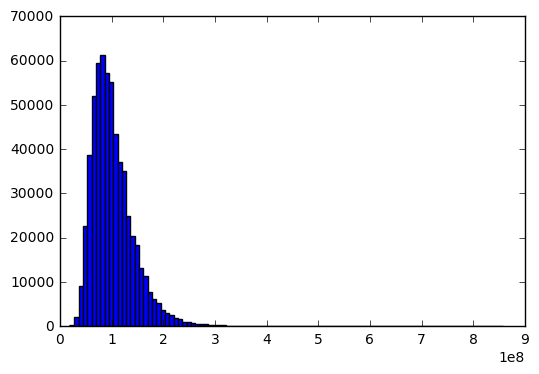

In [10]:
bln = 1000000000
N_sim = 1000000
k = 0.0018*N_sim #alpha = 0.9982, k = (1-alpha)*N_sim
EC = np.sort(Loss)[-k] - np.mean(Loss)
print(EC/bln)
plt.hist(Loss, bins=100)
plt.show()

In [11]:
L = Loss/np.max(Loss)

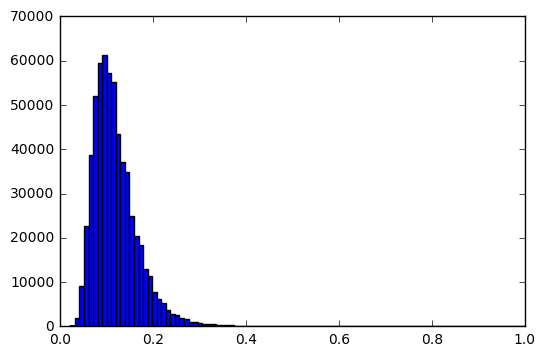

In [12]:
plt.hist(L, bins=100)
plt.show()

In [13]:
np.mean(L)

0.11937186114352392